In [125]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os
import pandas as pd
pd.set_option('display.max_columns', None)

from astropy.coordinates import SkyCoord
from scipy.stats import chi2
from scipy.optimize import minimize
from astropy.table import Table
from scipy.stats import linregress

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/lst1_systematics/scripts"))
import auxiliar as aux
import geometry as geom

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# ============================ #
dict_path = "objects/total_dicts/dict_total_0.252_50.pkl"
# ============================ #


#######################################
# intensity integration limits
#######################################

int_lim = [110, 140] #p.e.

bin_lims = [90, 110]

#######################################

### Reading all the objects and putting all the information in a unique dict

In [2]:
%%time
# reading dict
with open(dict_path, 'rb') as f:
    dict_total = pickle.load(f)

dict_runs    = dict_total["run"]
dict_general = dict_total["general"] 

Ibins  = dict_total["general"]["intensity_bins"]
IbinsC = dict_total["general"]["intensity_bins_centers"]

total_zds = [dict_runs[run]["zd"] for run in dict_runs.keys()]

# select the bins that are inside the integral
flag_bins = []
for i in range(len(Ibins)-1):
    if Ibins[i] > np.log10(int_lim[0]) and Ibins[i+1] < np.log10(int_lim[1]):
        flag_bins.append(True)
    else:
        flag_bins.append(False)

CPU times: user 7.98 ms, sys: 1.74 ms, total: 9.72 ms
Wall time: 8.17 ms


### Effective time correction

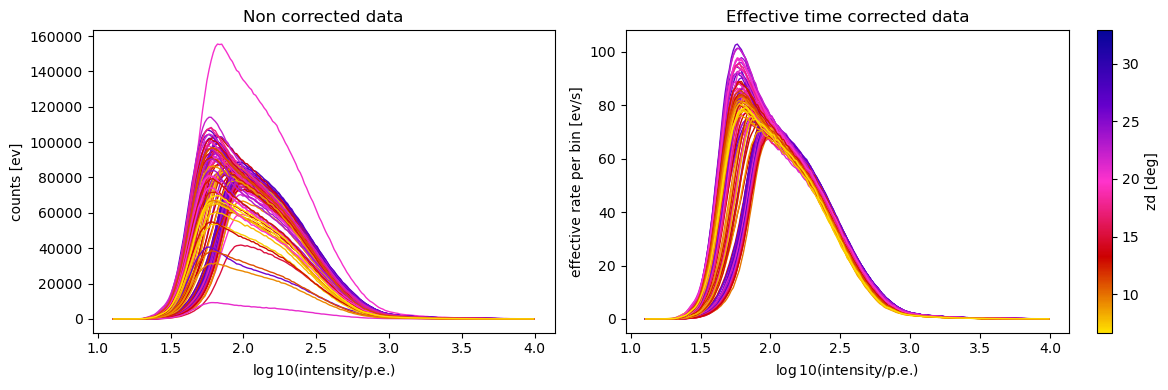

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1.2]})

# Getting the color array for the ZDs
colors = aux.get_colors_multiplot(total_zds, COLORS=list(reversed(aux.predC)))
cmap   = aux.create_cmap(list(reversed(aux.predC)))

# Then we plot the intensity profiles one by one
for i, run in enumerate(dict_runs.keys()):  
    ax1.plot(IbinsC, dict_runs[run]["intensity_rates"] * dict_runs[run]["effective_time"], color=colors[i], lw=1)
    ax2.plot(IbinsC, dict_runs[run]["intensity_rates"]                                   , color=colors[i], lw=1)

# creating a colorbar
aux.plot_colorbar(fig, ax2, total_zds, cmap, label="zd [deg]")

for ax in [ax1, ax2]:
    ax.set_xlabel("$\log10($intensity/p.e.$)$")
ax1.set_ylabel("counts [ev]")
ax2.set_ylabel("effective rate per bin [ev/s]")
ax1.set_title("Non corrected data")
ax2.set_title("Effective time corrected data")
fig.tight_layout()

# plt.savefig(f"plots/time_correction.png", dpi=300, bbox_inches='tight')
plt.show()

### Computing counts

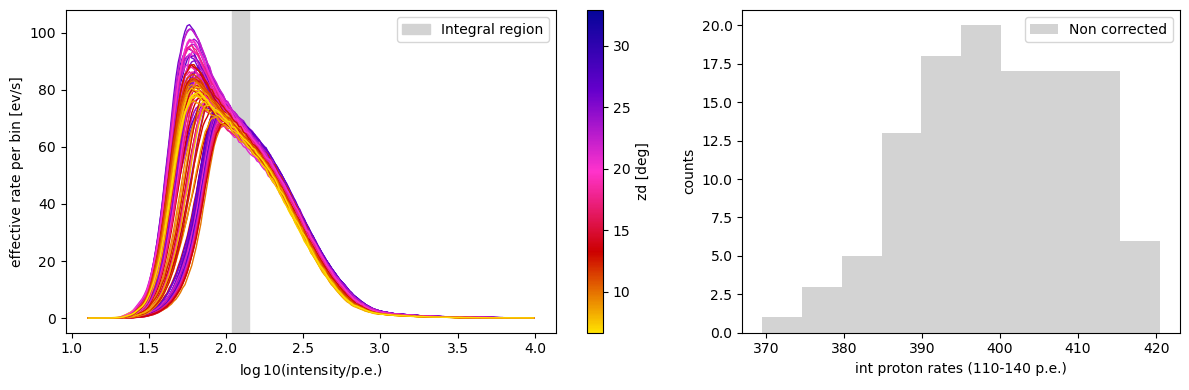

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1.4, 1]})

# Getting the color array for the ZDs
colors = aux.get_colors_multiplot(total_zds, COLORS=list(reversed(aux.predC)))
cmap   = aux.create_cmap(list(reversed(aux.predC)))

# Then we plot the intensity profiles one by one
p_rate = []
for i, run in enumerate(dict_runs.keys()):  
    
    rates = dict_runs[run]["intensity_rates"]
    ax1.plot(IbinsC, rates, color=colors[i], lw=1)
    
    # --- Compute the integral of p rate in the integral range --- #
    integral = np.sum(rates[flag_bins])
    
    dict_runs[run]["p_rate"] = integral
    p_rate.append(integral)
    
# creating a colorbar
aux.plot_colorbar(fig, ax1, total_zds, cmap, label="zd [deg]")

# Plotting the integral range
ax1.axvspan(np.log10(int_lim[0]), np.log10(int_lim[1]), color="lightgray", zorder=-10, label="Integral region")

# Plotting the proton rate histogram
ax2.hist(p_rate, color="lightgray", bins=int(np.sqrt(len(p_rate))), label="Non corrected")

for ax in [ax1, ax2]:
    ax.legend()
ax1.set_xlabel("$\log10($intensity/p.e.$)$")
ax2.set_xlabel(f"int proton rates ({int_lim[0]}-{int_lim[1]} p.e.)")
ax1.set_ylabel("effective rate per bin [ev/s]")
ax2.set_ylabel("counts")
fig.tight_layout()

# plt.savefig(f"plots/total.png", dpi=300, bbox_inches='tight')
plt.show()

### Extracting all the values in arrays

In [5]:
# extracting values as arrays
p_rate, e_p_rate = [], []
flux,   e_flux   = [], []
zd,     az       = [], []
e_zd,   e_az     = [], []

for run in np.sort(list(dict_runs.keys())):
    flux.append(dict_runs[run]["flux"])
    e_flux.append(dict_runs[run]["e_flux"])
    zd.append(dict_runs[run]["zd"])
    az.append(dict_runs[run]["az"])
    p_rate.append(dict_runs[run]["p_rate"])
    
    _e_p_rate = np.sqrt(dict_runs[run]["n_events"]) / dict_runs[run]["effective_time"]
    dict_runs[run]["e_p_rate"] = _e_p_rate
    e_p_rate.append(_e_p_rate)

for array in [flux, e_flux, p_rate, e_p_rate, zd, az]:
    array = np.array(array)

### Linearly fitting the zd to the proton rate and showing all distributions

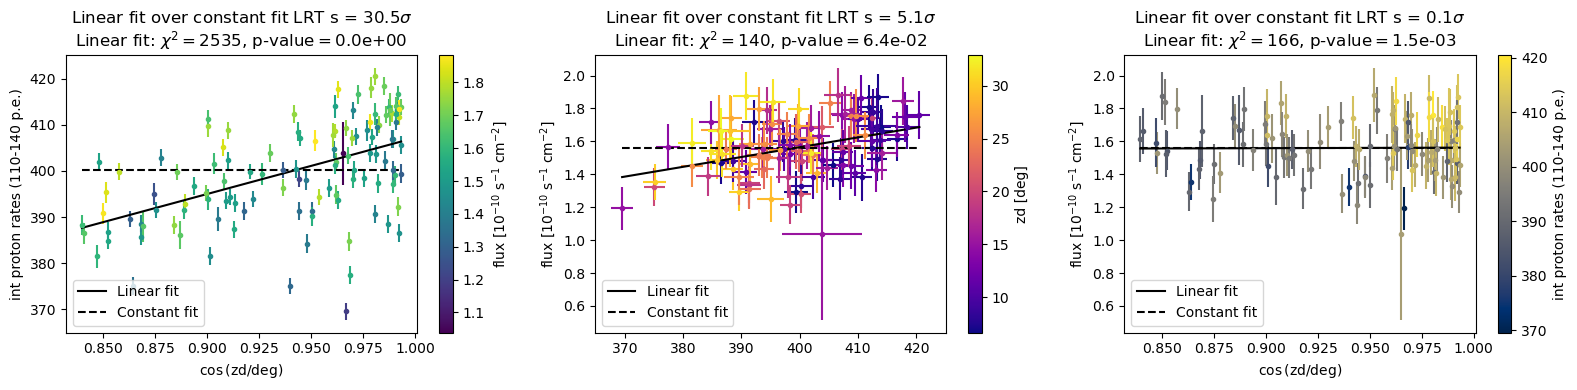

In [6]:
# Perform linear fits
fitF_zd_p = np.poly1d(np.polyfit(np.cos(np.deg2rad(zd)), p_rate, 1)) 
fitF_p_f  = np.poly1d(np.polyfit(p_rate,                 flux,   1)) 
fitF_zd_f = np.poly1d(np.polyfit(np.cos(np.deg2rad(zd)), flux,   1))

############################################
# plot the figures
############################################
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

norm_zd, colors_zd = aux.get_cmap_colors(zd, "plasma") 
norm_p,  colors_p  = aux.get_cmap_colors(p_rate, "cividis") 
norm_f,  colors_f  = aux.get_cmap_colors(flux, "viridis")

for i in range(len(az)):
    ax1.errorbar(np.cos(np.deg2rad(zd[i])), p_rate[i], xerr=0,           yerr=e_p_rate[i], ls="", marker=".", color=colors_f[i])
    ax2.errorbar(p_rate[i],                 flux[i],   xerr=e_p_rate[i], yerr=e_flux[i],   ls="", marker=".", color=colors_zd[i])
    ax3.errorbar(np.cos(np.deg2rad(zd[i])), flux[i],   xerr=0,           yerr=e_flux[i],   ls="", marker=".", color=colors_p[i])

# colorbars
aux.plot_colorbar(fig, ax1, flux,   "viridis",  label="flux [$10^{-10}$ s${}^{-1}$ cm${}^{-2}$]")
aux.plot_colorbar(fig, ax2, zd,     "plasma", label="zd [deg]")
aux.plot_colorbar(fig, ax3, p_rate, "cividis", label=f"int proton rates ({int_lim[0]}-{int_lim[1]} p.e.)")

# plot lines
zd_array = np.linspace(min(np.cos(np.deg2rad(zd))), max(np.cos(np.deg2rad(zd))), 200)
p_array  = np.linspace(min(p_rate), max(p_rate), 200)

LRT_zd_p = geom.LRTFreeConst(np.cos(np.deg2rad(zd)), p_rate, e_p_rate)
LRT_p_f  = geom.LRTFreeConst(p_rate,                 flux,   e_flux)
LRT_zd_f = geom.LRTFreeConst(np.cos(np.deg2rad(zd)), flux,   e_flux)

ch_zd_p, _, p_zd_p = aux.calculate_chi2_pvalue_fun(np.cos(np.deg2rad(zd)), p_rate, e_p_rate, geom.lineFreeF, LRT_zd_p[1])
ch_p_f,  _, p_p_f  = aux.calculate_chi2_pvalue_fun(p_rate,                 flux,   e_flux,   geom.lineFreeF, LRT_p_f[1])
ch_zd_f, _, p_zd_f = aux.calculate_chi2_pvalue_fun(np.cos(np.deg2rad(zd)), flux,   e_flux,   geom.lineFreeF, LRT_zd_f[1])

for ax, LRT, arr, ch, p in zip([ax1, ax2, ax3], [LRT_zd_p, LRT_p_f, LRT_zd_f], [zd_array, p_array, zd_array], [ch_zd_p, ch_p_f, ch_zd_f], [p_zd_p, p_p_f, p_zd_f]):
    
    ax.plot(arr, geom.lineFreeF(LRT[1],  arr), '-k',  label=f"Linear fit")
    ax.plot(arr, geom.lineConstF(LRT[2], arr), '--k', label=f"Constant fit")
    
    ax.legend(loc=3)
    ax.set_title(f"Linear fit over constant fit LRT s = {LRT[0]:.1f}{aux.sigma}\nLinear fit: $\chi^2=${ch:.0f}, p-value$=${p:.1e}")
    
    if ax == ax1 or ax == ax2:
        ax.set_ylabel(f"int proton rates ({int_lim[0]}-{int_lim[1]} p.e.)")
    if ax == ax2 or ax == ax3:
        ax.set_ylabel("flux [$10^{-10}$ s${}^{-1}$ cm${}^{-2}$]")
    if ax == ax1 or ax == ax3:
        ax.set_xlabel("$\cos$(zd/deg)")


fig.tight_layout()

# plt.savefig(f"plots/total.png", dpi=300, bbox_inches='tight')
plt.show()

### Re-scaling the proton rate as it should be in zd=0

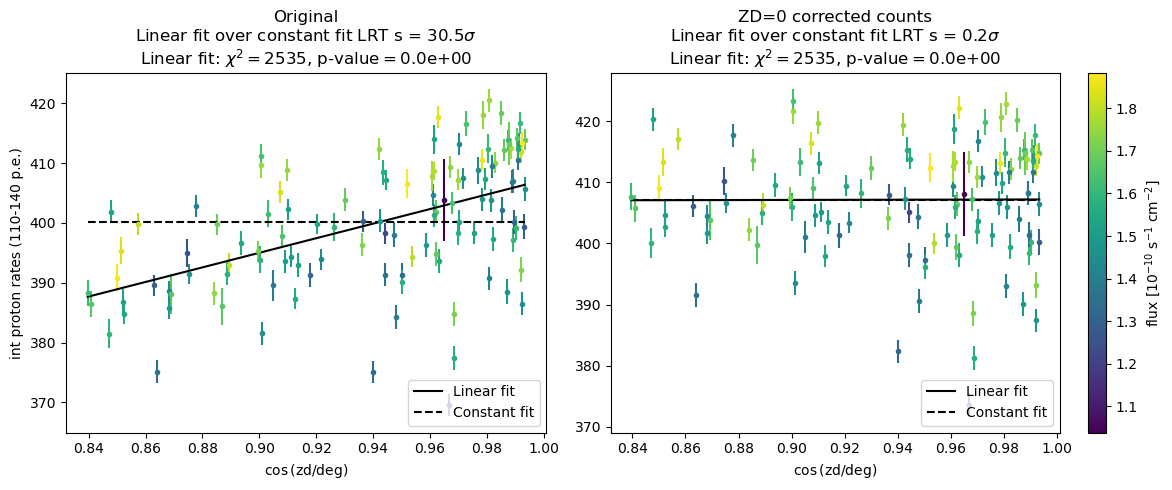

In [7]:
zd_0_p_rate = []
for run in dict_runs.keys():
    
    _zd_0_p_rate = dict_runs[run]["p_rate"] - fitF_zd_p(np.cos(np.deg2rad(dict_runs[run]["zd"]))) + fitF_zd_p(1)
    
    dict_runs[run]["zd_0_p_rate"] = _zd_0_p_rate
    zd_0_p_rate.append(_zd_0_p_rate)

    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.2, 1.4]})

norm_f,  colors_f  = aux.get_cmap_colors(flux, "viridis")

for i in range(len(az)):
    ax1.errorbar(np.cos(np.deg2rad(zd[i])), p_rate[i],      xerr=0, yerr=e_p_rate[i], ls="", marker=".", color=colors_f[i])
    ax2.errorbar(np.cos(np.deg2rad(zd[i])), zd_0_p_rate[i], xerr=0, yerr=e_p_rate[i], ls="", marker=".", color=colors_f[i])

aux.plot_colorbar(fig, ax2, flux, "viridis",  label="flux [$10^{-10}$ s${}^{-1}$ cm${}^{-2}$]")

# plot lines
LRT_zd_p   = geom.LRTFreeConst(np.cos(np.deg2rad(zd)), p_rate,      e_p_rate)
LRT_zd_0_p = geom.LRTFreeConst(np.cos(np.deg2rad(zd)), zd_0_p_rate, e_p_rate)

ch_zd_p,   _, p_zd_p   = aux.calculate_chi2_pvalue_fun(np.cos(np.deg2rad(zd)), p_rate,      e_p_rate, geom.lineFreeF, LRT_zd_p[1])
ch_zd_0_p, _, p_zd_0_p = aux.calculate_chi2_pvalue_fun(np.cos(np.deg2rad(zd)), zd_0_p_rate, e_p_rate, geom.lineFreeF, LRT_zd_0_p[1])

for ax, LRT in zip([ax1, ax2], [LRT_zd_p, LRT_zd_0_p]):   
    ax.plot(zd_array, geom.lineFreeF( LRT[1], zd_array), '-k',  label=f"Linear fit")
    ax.plot(zd_array, geom.lineConstF(LRT[2], zd_array), '--k', label=f"Constant fit")

for ax in [ax1, ax2]:
    ax.legend(loc=4)
    ax.set_xlabel("$\cos$(zd/deg)")
ax1.set_ylabel(f"int proton rates ({int_lim[0]}-{int_lim[1]} p.e.)")
ax1.set_title("Original proton rates")
ax2.set_title("ZD corrected proton rates")

for ax, LRT, ch, p, t in zip([ax1, ax2], [LRT_zd_p, LRT_zd_0_p], [ch_zd_p, ch_zd_0_p], [p_zd_p, p_zd_0_p], ["Original", "ZD=0 corrected counts"]):
    ax.set_title(f"{t}\nLinear fit over constant fit LRT s = {LRT[0]:.1f}{aux.sigma}\nLinear fit: $\chi^2=${ch:.0f}, p-value$=${p:.1e}")

fig.tight_layout()
# plt.savefig(f"plots/total.png", dpi=300, bbox_inches='tight')
plt.show()

### Fitting the flux vs the proton rate with a stright line passing trough (0,0)

In [8]:
LRT_p_f   = geom.LRTFreeZero(p_rate,      flux, e_flux)
LRT_0_p_f = geom.LRTFreeZero(zd_0_p_rate, flux, e_flux)
    
zd_corr_flux = []
for run in dict_runs.keys():
    _factor = geom.lineZeroF(dict_runs[run]["zd_0_p_rate"], LRT_0_p_f[2]) / dict_runs[run]["flux"]
    dict_runs[run]["zd_corr"] = _factor
    
    _zd_corr_flux = dict_runs[run]["flux"] - (geom.lineZeroF(dict_runs[run]["zd_0_p_rate"], LRT_0_p_f[2]) - np.mean(flux))
    
    zd_corr_flux.append(_zd_corr_flux[0])
    dict_runs[run]["zd_corr_flux"] = _zd_corr_flux[0]

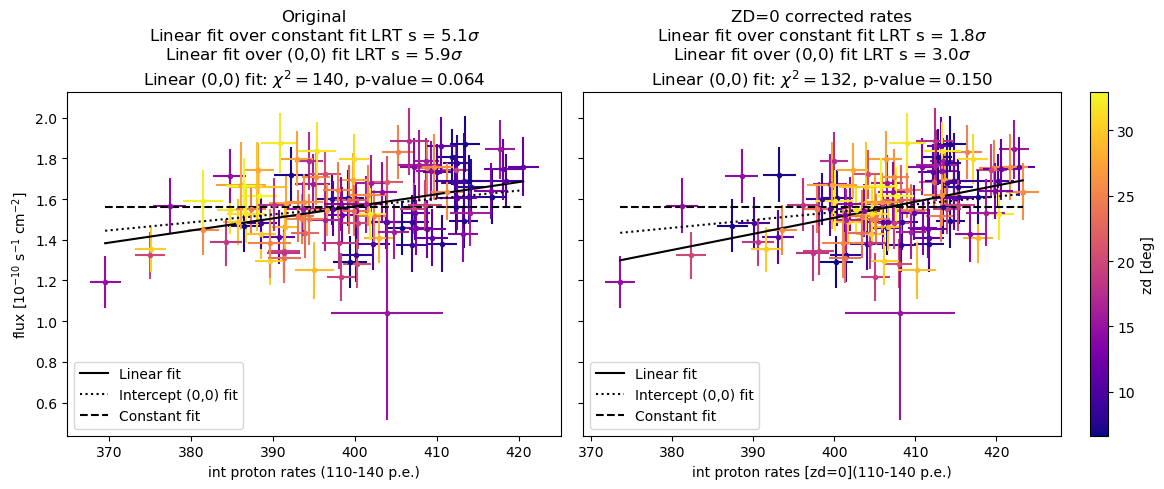

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.2, 1.45]}, sharey=True)

norm_zd, colors_zd = aux.get_cmap_colors(zd, "plasma") 

for i in range(len(az)):
    ax1.errorbar(p_rate[i],      flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])
    ax2.errorbar(zd_0_p_rate[i], flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])

aux.plot_colorbar(fig, ax2, zd,     "plasma", label="zd [deg]")


p_array      = np.linspace(min(p_rate),      max(p_rate),      200)
corr_p_array = np.linspace(min(zd_0_p_rate), max(zd_0_p_rate), 200)

LRT_p_f        = geom.LRTFreeConst(p_rate,      flux, e_flux)
LRT_corr_p_f   = geom.LRTFreeConst(zd_0_p_rate, flux, e_flux)
LRT_p_f_0      = geom.LRTFreeZero(p_rate,       flux, e_flux)
LRT_corr_p_f_0 = geom.LRTFreeZero(zd_0_p_rate,  flux, e_flux)

ch_zd_0_p,      _, p_zd_0_p      = aux.calculate_chi2_pvalue_fun(p_rate,      flux, e_flux, geom.lineFreeF, LRT_p_f_0[1])
ch_corr_zd_0_p, _, p_corr_zd_0_p = aux.calculate_chi2_pvalue_fun(zd_0_p_rate, flux, e_flux, geom.lineFreeF, LRT_corr_p_f_0[1])


for ax, LRT1, LRT2, LRTa, LRTb, parr, ch, p, t in zip([ax1, ax2], [LRT_p_f, LRT_corr_p_f], [LRT_p_f_0, LRT_corr_p_f_0], [LRT_p_f, LRT_p_f_0], [LRT_corr_p_f, LRT_corr_p_f_0],
                                                   [p_array, corr_p_array], [ch_zd_0_p, ch_corr_zd_0_p], [p_zd_0_p, p_corr_zd_0_p], ["Original", "ZD=0 corrected rates"]):

    ax.plot(parr, geom.lineFreeF(LRT1[1],  parr), '-k',  label=f"Linear fit")
    ax.plot(parr, geom.lineZeroF(LRT2[2],  parr), ':k',  label=f"Intercept (0,0) fit")
    ax.plot(parr, geom.lineConstF(LRT1[2], parr), '--k', label=f"Constant fit")
    
    ax.legend(loc=3)
    _title = f"{t}\nLinear fit over constant fit LRT s = {LRTa[0]:.1f}{aux.sigma}\nLinear fit over (0,0) fit LRT s = {LRTb[0]:.1f}{aux.sigma}"
    _title = _title + f"\nLinear (0,0) fit: $\chi^2=${ch:.0f}, p-value$=${p:.3f}"
    ax.set_title(_title)
    
ax1.set_ylabel("flux [$10^{-10}$ s${}^{-1}$ cm${}^{-2}$]")
ax1.set_xlabel(f"int proton rates ({int_lim[0]}-{int_lim[1]} p.e.)")
ax2.set_xlabel(f"int proton rates [zd=0]({int_lim[0]}-{int_lim[1]} p.e.)")

fig.tight_layout()
# plt.savefig(f"plots/total.png", dpi=300, bbox_inches='tight')
plt.show()

### Plotting the corrections

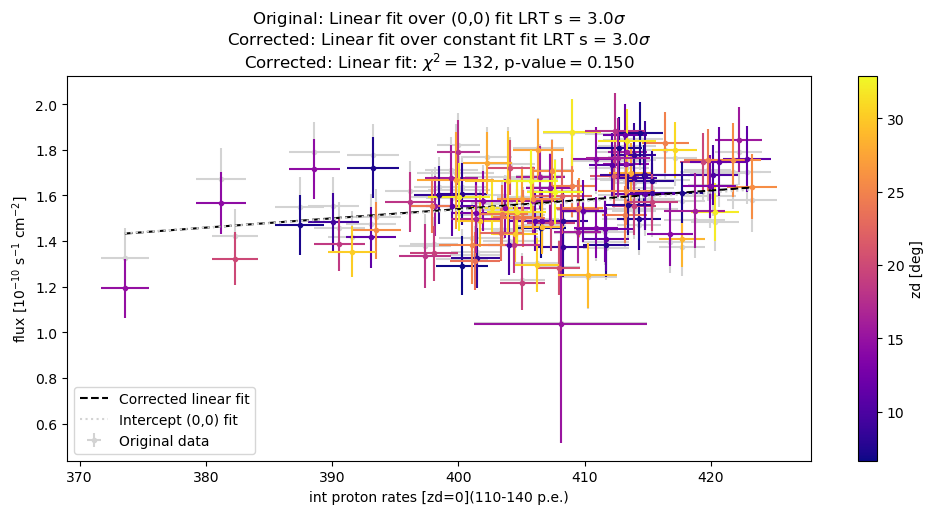

In [10]:
fig, ax = plt.subplots(figsize=(12, 5))

norm_zd, colors_zd = aux.get_cmap_colors(zd, "plasma") 

for i in range(len(az)):
    ax.errorbar(zd_0_p_rate[i], flux[i],         xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])
ax.errorbar(zd_0_p_rate, zd_corr_flux, xerr=e_p_rate, yerr=e_flux, ls="", marker=".", color="lightgray", zorder=-1, label="Original data")
aux.plot_colorbar(fig, ax, zd,     "plasma", label="zd [deg]")

corr_p_array = np.linspace(min(zd_0_p_rate), max(zd_0_p_rate), 200)
LRT_corr_p_f = geom.LRTFreeConst(zd_0_p_rate, zd_corr_flux, e_flux)
LRT_p_f_0    = geom.LRTFreeZero( zd_0_p_rate, flux,         e_flux)
ch_corr_p_f, _, p_corr_p_f = aux.calculate_chi2_pvalue_fun(zd_0_p_rate, zd_corr_flux, e_flux, geom.lineFreeF, LRT_corr_p_f[1])
ch_p_f_0,    _, p_p_f_0    = aux.calculate_chi2_pvalue_fun(zd_0_p_rate, flux,         e_flux, geom.lineZeroF, LRT_p_f_0[2])

ax.plot(corr_p_array, geom.lineFreeF(LRT_corr_p_f[1], corr_p_array), '--k', label=f"Corrected linear fit")
ax.plot(corr_p_array, geom.lineZeroF(LRT_p_f_0[2],    corr_p_array), ':', color="lightgray", label=f"Intercept (0,0) fit")
    
ax.legend(loc=3)
    
_title = f"Original: Linear fit over (0,0) fit LRT s = {LRT_p_f_0[0]:.1f}{aux.sigma}\nCorrected: Linear fit over constant fit LRT s = {LRT_corr_p_f[0]:.1f}{aux.sigma}"
_title = _title + f"\nCorrected: Linear fit: $\chi^2=${ch_corr_p_f:.0f}, p-value$=${p_corr_p_f:.3f}"
ax.set_title(_title)
    
ax.set_ylabel("flux [$10^{-10}$ s${}^{-1}$ cm${}^{-2}$]")
ax.set_xlabel(f"int proton rates [zd=0]({int_lim[0]}-{int_lim[1]} p.e.)")

# plt.savefig(f"plots/total.png", dpi=300, bbox_inches='tight')
plt.show()

### New distributions

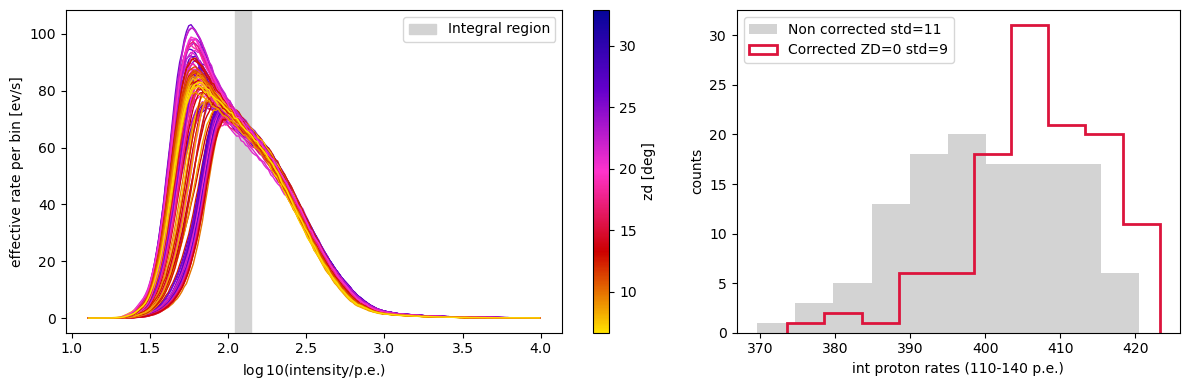

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1.4, 1]})

# Getting the color array for the ZDs
colors = aux.get_colors_multiplot(total_zds, COLORS=list(reversed(aux.predC)))
cmap   = aux.create_cmap(list(reversed(aux.predC)))

# Then we plot the intensity profiles one by one
_zd_0_p_rate = []
for i, run in enumerate(dict_runs.keys()):  
    
    rates = dict_runs[run]["intensity_rates"] * dict_runs[run]["zd_0_p_rate"] / dict_runs[run]["p_rate"]
    ax1.plot(IbinsC, rates, color=colors[i], lw=1)
    
    # --- Compute the integral of p rate in the integral range --- #
    integral = np.sum(rates[flag_bins])
    
    dict_runs[run]["zd_0_p_rate"] = integral
    _zd_0_p_rate.append(integral)
    
# creating a colorbar
aux.plot_colorbar(fig, ax1, total_zds, cmap, label="zd [deg]")

# Plotting the integral range
ax1.axvspan(np.log10(int_lim[0]), np.log10(int_lim[1]), color="lightgray", zorder=-10, label="Integral region")

# Plotting the proton rate histogram
ax2.hist(p_rate, color="lightgray", bins=int(np.sqrt(len(p_rate))), label=f"Non corrected std={np.std(p_rate):.0f}")
ax2.hist(_zd_0_p_rate, color="crimson", bins=int(np.sqrt(len(p_rate))), histtype="step", lw=2, label=f"Corrected ZD=0 std={np.std(_zd_0_p_rate):.0f}")

ax1.legend(loc=1)
ax2.legend(loc=2)
ax1.set_xlabel("$\log10($intensity/p.e.$)$")
ax2.set_xlabel(f"int proton rates ({int_lim[0]}-{int_lim[1]} p.e.)")
ax1.set_ylabel("effective rate per bin [ev/s]")
ax2.set_ylabel("counts")
fig.tight_layout()

# plt.savefig(f"plots/total.png", dpi=300, bbox_inches='tight')
plt.show()

### Plotting the Light Curve

In [12]:
chi, zd_corr_chi = [], []

for run in dict_runs.keys():
    chi.append(        (dict_runs[run]["flux"]         - np.mean(flux))         / dict_runs[run]["e_flux"])
    zd_corr_chi.append((dict_runs[run]["zd_corr_flux"] - np.mean(zd_corr_flux)) / dict_runs[run]["e_flux"])

chi, zd_corr_chi = np.array(chi), np.array(zd_corr_chi)

chi2_,      _, p_val      = aux.calculate_chi2_pvalue_const(flux,         e_flux, sys_error=0)
corr_chi2_, _, corr_p_val = aux.calculate_chi2_pvalue_const(zd_corr_flux, e_flux, sys_error=0)

mean_flux, mean_flux_error = aux.weighted_average(zd_corr_flux, e_flux)

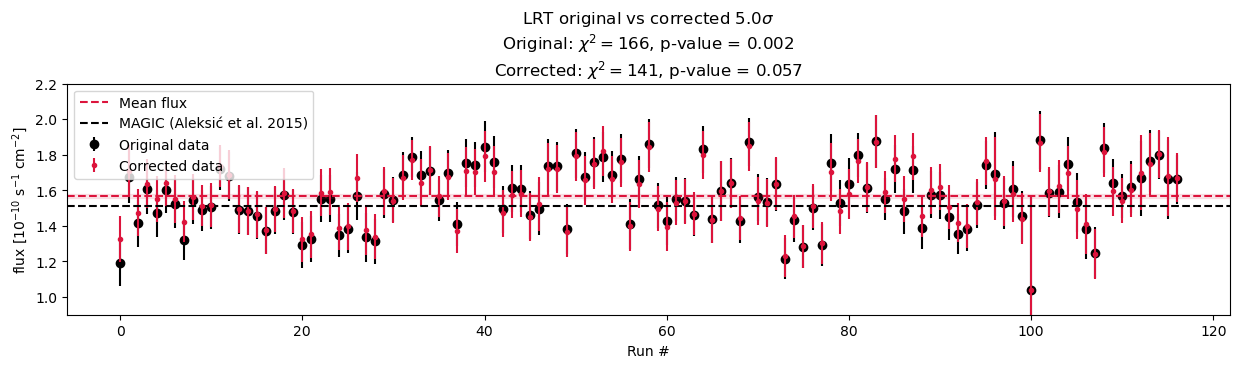

In [13]:
fig, ax = plt.subplots(figsize=(15, 3))
    
ax.errorbar(np.arange(len(flux)), flux,         yerr=e_flux, marker="o", ls="", color="k",  zorder=-10, label="Original data")
ax.errorbar(np.arange(len(flux)), zd_corr_flux, yerr=e_flux, marker=".", ls="", color="crimson", label="Corrected data")

ax.axhspan(mean_flux - mean_flux_error, mean_flux + mean_flux_error, color="crimson", alpha=0.1)
ax.axhline(mean_flux, color="crimson", ls="--", label=f"Mean flux")
     
ax.axhline(dict_general["crab_reference_flux"], color="k", ls="--", label="MAGIC (Aleksić et al. 2015)")    
ax.legend(loc=2)
        
lrt_sig = np.sqrt(chi2_ - corr_chi2_)
_title = f"LRT original vs corrected {lrt_sig:.1f}{aux.sigma}\nOriginal: $\chi^2 = ${chi2_:.0f}, p-value = {p_val:.3f}"
_title = _title + f"\nCorrected: $\chi^2 = ${corr_chi2_:.0f}, p-value = {corr_p_val:.3f}"
ax.set_title(_title)
ax.set_ylabel("flux [$10^{-10}$ s${}^{-1}$ cm${}^{-2}$]")
ax.set_xlabel("Run #")
ax.set_ylim(0.9, 2.2)
# plt.savefig(f"plots/total.png", dpi=300, bbox_inches='tight')
plt.show()

### Calculating the chi2 distributions

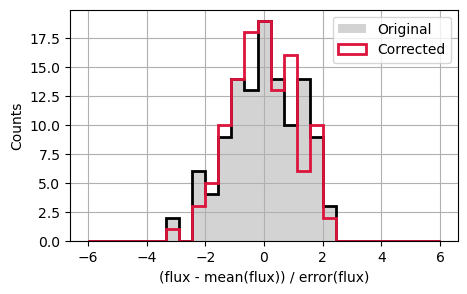

In [14]:
N = 28
bins = np.linspace(-6, 6, N)

fig, ax = plt.subplots(figsize=(5, 3))

ax.hist(np.array(chi),         bins=bins, color="lightgray",  label=f"Original")
ax.hist(np.array(chi),         bins=bins, color="k", lw=2, histtype="step")
ax.hist(np.array(zd_corr_chi), bins=bins, color="crimson", histtype="step", lw=2, label=f"Corrected")

ax.legend()
plt.grid()
ax.set_ylabel("Counts")
ax.set_xlabel("(flux - mean(flux)) / error(flux)")
# plt.savefig(f"plots/total.png", dpi=300, bbox_inches='tight')
plt.show()

## Total Light Curve fitting

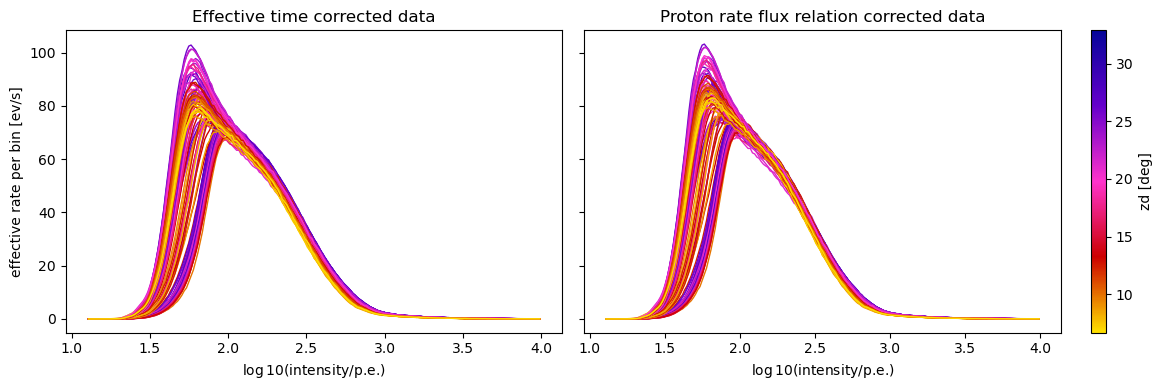

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1.2]}, sharey=True)

# Getting the color array for the ZDs
colors = aux.get_colors_multiplot(total_zds, COLORS=list(reversed(aux.predC)))
cmap   = aux.create_cmap(list(reversed(aux.predC)))

# Then we plot the intensity profiles one by one
for i, run in enumerate(dict_runs.keys()):  
    ax2.plot(IbinsC, dict_runs[run]["intensity_rates"] * dict_runs[run]["zd_0_p_rate"] / dict_runs[run]["p_rate"], color=colors[i], lw=1)
    ax1.plot(IbinsC, dict_runs[run]["intensity_rates"], color=colors[i], lw=1)

# creating a colorbar
aux.plot_colorbar(fig, ax2, total_zds, cmap, label="zd [deg]")

for ax in [ax1, ax2]:
    ax.set_xlabel("$\log10($intensity/p.e.$)$")

ax1.set_ylabel("effective rate per bin [ev/s]")
ax1.set_title("Effective time corrected data")
ax2.set_title("Proton rate flux relation corrected data")
fig.tight_layout()
# plt.savefig(f"plots/total.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
slopes, intercepts = [], []

for i, run in enumerate(dict_runs.keys()): 
    x = (IbinsC)[bin_lims]
    y = (dict_runs[run]["intensity_rates"] * dict_runs[run]["zd_0_p_rate"] / dict_runs[run]["p_rate"])[bin_lims]

    # Perform linear regression
    slope, intercept, _, _, _ = linregress(x, y)

    # Append slope and intercept to the lists
    slopes.append(slope)
    intercepts.append(intercept)

slopes, intercepts = np.array(slopes), np.array(intercepts)
mSlope, mIntercept = np.mean(slopes), np.mean(intercepts)

rates_fixed_point = np.mean([mIntercept + IbinsC[bin_lims[0]] * mSlope, mIntercept + IbinsC[bin_lims[-1]] * mSlope])
rates_fixed_point1 = mIntercept + IbinsC[bin_lims[0]] * mSlope
rates_fixed_point2 = mIntercept + IbinsC[bin_lims[-1]] * mSlope

displacements, displacements1, displacements2 = [], [], []
for i, run in enumerate(dict_runs.keys()):
    
    x0  = (rates_fixed_point - intercepts[i]) / slopes[i]
    mx0 = (rates_fixed_point - mIntercept) / mSlope
    displacements.append(mx0 - x0)

    x0  = (rates_fixed_point1 - intercepts[i]) / slopes[i]
    mx0 = (rates_fixed_point1 - mIntercept) / mSlope
    displacements1.append(mx0 - x0)
    
    x0  = (rates_fixed_point2 - intercepts[i]) / slopes[i]
    mx0 = (rates_fixed_point2 - mIntercept) / mSlope
    displacements2.append(mx0 - x0)

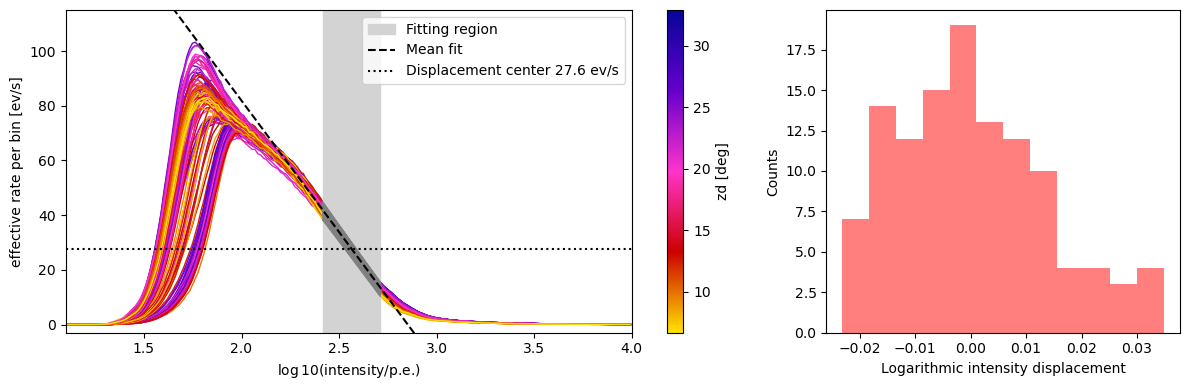

In [17]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1]})

# Getting the color array for the ZDs
colors = aux.get_colors_multiplot(total_zds, COLORS=list(reversed(aux.predC)))
cmap   = aux.create_cmap(list(reversed(aux.predC)))

for i, run in enumerate(dict_runs.keys()): 
    
    rates = dict_runs[run]["intensity_rates"] * dict_runs[run]["zd_0_p_rate"] / dict_runs[run]["p_rate"]
  
    ax.plot((IbinsC)[bin_lims], (dict_runs[run]["intensity_rates"] * dict_runs[run]["zd_0_p_rate"] / dict_runs[run]["p_rate"])[bin_lims], color="gray", lw=1)
    ax.plot(IbinsC, dict_runs[run]["intensity_rates"] * dict_runs[run]["zd_0_p_rate"] / dict_runs[run]["p_rate"], color=colors[i], lw=1, zorder=-10)

# creating a colorbar
aux.plot_colorbar(fig, ax, total_zds, cmap, label="zd [deg]")

ax.axvspan(IbinsC[bin_lims[0]], IbinsC[bin_lims[1]], color="lightgray", label="Fitting region")
ax.plot(IbinsC, geom.lineFreeF([mSlope, mIntercept], IbinsC), color="k", ls="--", label="Mean fit")
ax.axhline(rates_fixed_point, color="k", ls=":", label=f"Displacement center {rates_fixed_point:.1f} ev/s")
ax2.hist(displacements, bins=12, color="red", alpha=0.5)

ax.legend()
ax.set_ylim(-3, 115)
ax.set_xlim(1.1, 4)
ax.set_xlabel("$\log10($intensity/p.e.$)$")
ax.set_ylabel("effective rate per bin [ev/s]")
ax2.set_xlabel("Logarithmic intensity displacement")
ax2.set_ylabel("Counts")
fig.tight_layout()

# plt.savefig(f"plots/total.png", dpi=300, bbox_inches='tight')
plt.show()

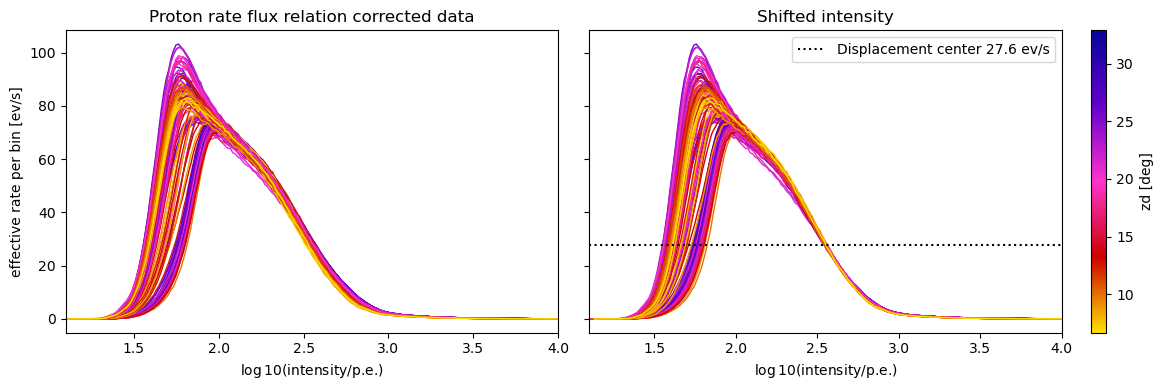

In [18]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [1, 1.2]}, sharey=True)

# Getting the color array for the ZDs
colors = aux.get_colors_multiplot(total_zds, COLORS=list(reversed(aux.predC)))
cmap   = aux.create_cmap(list(reversed(aux.predC)))

# Then we plot the intensity profiles one by one
for i, run in enumerate(dict_runs.keys()):  
    ax2.plot(
        IbinsC, 
        dict_runs[run]["intensity_rates"] * dict_runs[run]["zd_0_p_rate"] / dict_runs[run]["p_rate"], 
        color=colors[i], lw=1
    )
    ax1.plot(
#         IbinsC + displacements[i], 
#         IbinsC + displacements2[i], 
        IbinsC + displacements2[i]/2 + displacements2[i]/2, 
        dict_runs[run]["intensity_rates"] * dict_runs[run]["zd_0_p_rate"] / dict_runs[run]["p_rate"],
        color=colors[i], lw=1
    )

# creating a colorbar
aux.plot_colorbar(fig, ax1, total_zds, cmap, label="zd [deg]")

for ax in [ax1, ax2]:
    ax.set_xlabel("$\log10($intensity/p.e.$)$")
    ax.set_xlim(1.1, 4)

ax1.axhline(rates_fixed_point, color="k", ls=":", label=f"Displacement center {rates_fixed_point:.1f} ev/s")

ax1.legend()
ax2.set_ylabel("effective rate per bin [ev/s]")
ax1.set_title(f"Shifted intensity")
ax2.set_title("Proton rate flux relation corrected data")
fig.tight_layout()

# plt.savefig(f"plots/total.png", dpi=300, bbox_inches='tight')
plt.show()

### Pressure correlation

In [20]:
ws_path = "objects/WS2003-22_short.h5"

df = pd.read_hdf(ws_path)

dates_ws    = np.array([datetime.fromisoformat(str(d).split(".")[0]) for d in np.array(df.index)])
pressure_ws = np.array(df["pressure"])
dust_ws     = np.array(df["tngDust"])
seeing_ws   = np.array(df["tngSeeing"])

dates = []
for i, d in enumerate(np.sort(list(dict_runs.keys()))):
    dates.append(dict_runs[d]["timestamp"])

In [126]:
df

,sun_alt,sun_az,fBits,mjd,temperature,pressure,windDirection,humidity,windSpeedCurrent,windGust,windSpeedAverage,windDirectionAverage,tempSensor,tngDust,tngSeeing,rain,state,Any,Mes,DP,diff1,is_dup,temperatureR
2003-01-30 15:01:20,38.049360,209.643614,33554432,-2330.374074,1.00,786.823231,127.00,99.80,13.60,13.90,-999.00,-999.00,-999.0,-999.00,-999.00,-1,255,2003,1,0.070628,0 days 00:00:00,NaN,1.000000
2003-01-30 15:03:20,37.831142,210.180579,33554432,-2330.372685,1.00,786.823231,106.00,99.80,22.10,22.20,-999.00,-999.00,-999.0,-999.00,-999.00,-1,255,2003,1,0.070628,0 days 00:02:00,NaN,1.000000
2003-01-30 15:05:20,37.609386,210.713618,33554432,-2330.371296,1.00,786.723088,59.00,99.80,19.80,20.40,-999.00,-999.00,-999.0,-999.00,-999.00,-1,255,2003,1,0.070628,0 days 00:02:00,NaN,1.033333
2003-01-30 15:07:20,37.384135,211.242719,33554432,-2330.369907,1.10,786.723088,103.00,98.40,21.90,23.10,-999.00,-999.00,-999.0,-999.00,-999.00,-1,255,2003,1,0.063730,0 days 00:02:00,NaN,1.066667
2003-01-30 15:09:20,37.155435,211.767874,33554432,-2330.368519,1.10,786.723088,137.00,97.50,29.80,30.20,-999.00,-999.00,-999.0,-999.00,-999.00,-1,255,2003,1,0.054542,0 days 00:02:00,NaN,1.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 23:50:00,-70.263478,281.758703,33554432,4943.993056,5.74,789.630000,106.41,91.41,18.42,29.68,22.62,111.70,0.0,13.15,1.42,0,24,2022,12,0.318846,0 days 00:01:59,NaN,5.696667
2022-12-30 23:52:01,-70.695571,282.260801,33554432,4943.994456,5.56,789.630000,107.51,92.18,21.56,26.69,22.29,110.55,0.0,13.15,1.42,0,24,2022,12,0.314717,0 days 00:02:01,NaN,5.616667
2022-12-30 23:54:00,-71.119707,282.771629,33554432,4943.995833,5.55,789.640000,117.36,92.43,23.76,33.21,26.16,116.67,0.0,13.15,1.42,0,24,2022,12,0.316729,0 days 00:01:59,NaN,5.566667
2022-12-30 23:56:00,-71.546523,283.305017,33554432,4943.997222,5.59,789.570000,84.88,91.92,28.99,36.19,26.52,108.29,0.0,13.15,1.42,0,24,2022,12,0.313980,0 days 00:02:00,NaN,5.576667


In [75]:
indexes = []
press, dust, see = [], [], []
for date in dates:
    deltas = np.abs([(date - d).total_seconds() for d in dates_ws])
    index = np.argmin(deltas)
    press.append(pressure_ws[index])
    dust.append(dust_ws[index])
    see.append(seeing_ws[index])
    
press = np.array(press)
dust  = np.array(dust)
see   = np.array(see)
p_rate = np.array(p_rate)
zd_0_p_rate = np.array(zd_0_p_rate)
e_p_rate = np.array(e_p_rate)

In [119]:
fit1 = np.poly1d(np.polyfit(dust, zd_0_p_rate/2, 1)) 
fit2 = np.poly1d(np.polyfit(see[see > 0.], zd_0_p_rate[see > 0.]/2, 1)) 
fit3 = np.poly1d(np.polyfit(press, zd_0_p_rate/2, 1)) 
_fit1 = np.poly1d(np.polyfit(dust, p_rate/2, 1)) 
_fit2 = np.poly1d(np.polyfit(see[see > 0.], p_rate[see > 0.]/2, 1)) 
_fit3 = np.poly1d(np.polyfit(press, p_rate/2, 1)) 

In [115]:
c1, _, p1 = aux.calculate_chi2_pvalue_fun(dust, zd_0_p_rate/2, e_p_rate, geom.lineFreeF, list(fit1))
c2, _, p2 = aux.calculate_chi2_pvalue_fun(see[see > 0.], zd_0_p_rate[see > 0.]/2, e_p_rate[see > 0.], geom.lineFreeF, list(fit2))
c3, _, p3 = aux.calculate_chi2_pvalue_fun(press, zd_0_p_rate/2, e_p_rate, geom.lineFreeF, list(fit3))

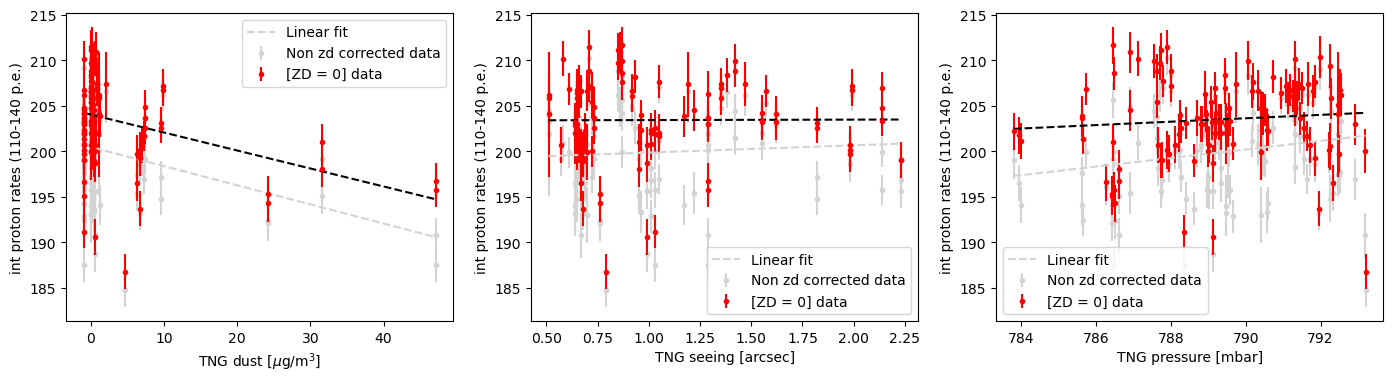

In [128]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 4))

ax1.errorbar(dust, p_rate/2, yerr=e_p_rate, color="lightgray", ls="", marker=".", zorder=-1, label="Non zd corrected data")
ax2.errorbar(see[see > 0.], p_rate[see > 0.]/2, yerr=e_p_rate[see > 0.], color="lightgray", ls="", marker=".", zorder=-1, label="Non zd corrected data")
ax3.errorbar(press, p_rate/2, yerr=e_p_rate, color="lightgray", ls="", marker=".", zorder=-1, label="Non zd corrected data")

ax1.errorbar(dust, zd_0_p_rate/2, yerr=e_p_rate , color="r", ls="", marker=".", label="[ZD = 0] data")
ax2.errorbar(see[see > 0.], zd_0_p_rate[see > 0.]/2, yerr=e_p_rate[see > 0.], color="r", ls="", marker=".", label="[ZD = 0] data")
ax3.errorbar(press, zd_0_p_rate/2, yerr=e_p_rate, color="r", ls="", marker=".", label="[ZD = 0] data")

d_a = np.linspace(min(dust), max(dust))
s_a = np.linspace(min(see[see > 0.]), max(see[see > 0.]))
p_a = np.linspace(min(press), max(press))


ax1.plot(d_a, geom.lineFreeF(list(_fit1), d_a), color="lightgray", ls="--", label="Linear fit")
ax2.plot(s_a, geom.lineFreeF(list(_fit2), s_a), color="lightgray", ls="--", label="Linear fit")
ax3.plot(p_a, geom.lineFreeF(list(_fit3), p_a), color="lightgray", ls="--", label="Linear fit")
ax1.plot(d_a, geom.lineFreeF(list(fit1), d_a), color="k", ls="--")
ax2.plot(s_a, geom.lineFreeF(list(fit2), s_a), color="k", ls="--")
ax3.plot(p_a, geom.lineFreeF(list(fit3), p_a), color="k", ls="--")

for ax in [ax1, ax2, ax3]:
    ax.set_ylabel(f"int proton rates ({int_lim[0]}-{int_lim[1]} p.e.)")
    ax.legend()

ax1.set_xlabel("TNG dust [$\\mu$g/m$^3$]")
ax2.set_xlabel("TNG seeing [arcsec]")
ax3.set_xlabel("TNG pressure [mbar]")
    
# plt.savefig(f"plots/total.png", dpi=300, bbox_inches='tight')
plt.show()

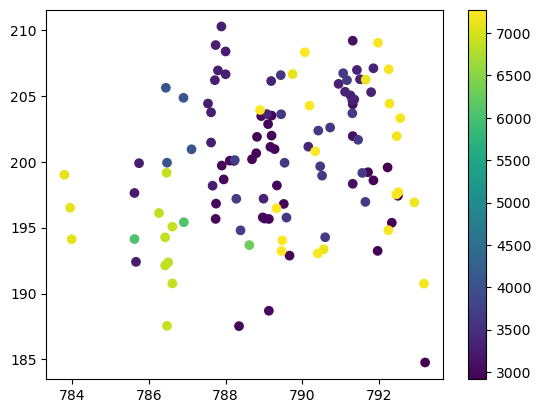

In [132]:
plt.scatter(press, p_rate/2, c=run_n)
plt.colorbar()